In [1]:
import os
import sys
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_auc_score, roc_curve

sys.path.append('../../1_dock/')
sys.path.append('../../ifp/')
sys.path.append('../../mcss/')
sys.path.append('../../3_analyze/')
from shared_paths import shared_paths
from containers import Protein
from density_estimate import DensityEstimate

%matplotlib inline

In [2]:
max_proteins = 100
max_ligands = 5
max_poses = 30
proteins = [fname for fname in os.listdir(shared_paths['data']) if fname[0] != '.']

data = {}
for protein in proteins[:max_proteins]:
    print protein
    prot = Protein(protein)
    lm = prot.lm
    ligands = lm.docked(lm.pdb)[:max_ligands+1]
    self_docked = lm.st+'_lig'
    if self_docked in ligands:
        ligands.remove(self_docked)
    else:
        ligands.pop(-1)
    prot.load_docking(ligands, load_fp = True)
    
    data[protein] = {}
    for ligand in ligands:
        data[protein][ligand] = []
        for pose in prot.docking[lm.st].ligands[ligand].poses[:max_poses]:
            data[protein][ligand] += [(pose.gscore, pose.fp, pose.rmsd)]

O60885
GCR
BRAF
DTRANSP
P00749
SMO
P03951
AR
MEK1
5HT2B
P00760
CDK2
SIGMA1
JAK2
ERA
P18031
P00489
A2AR
PLK1
VITD
GLUT1
MGLUR5
STRANSP
B2AR
TRPV1
Q9Y233
P00734
MR
M3
Q16539
P00742
P56817
P07900
P24941
B1AR
CHK1


In [3]:
def overlap(pose1, pose2, codes):
    return sum(np.sqrt(score1*pose2[1][(c, r)])
               for (c, r), score1 in pose1[1].items()
               if c in codes and (c, r) in pose2[1])

def get_norm(poses1, poses2, codes):
    norm = 0
    for pose1 in poses1:
        for pose2 in poses2:
            norm = max(norm, overlap(pose1, pose2, codes))
    return norm

# How well do features separate native and decoy poses? (pose average)

[1]


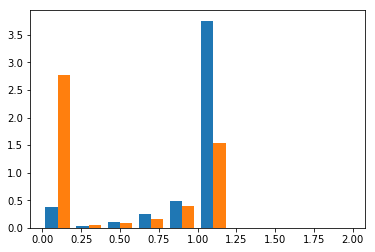

74406 0.76507726484


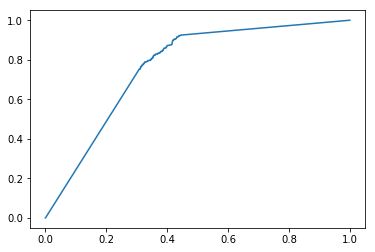

[2]


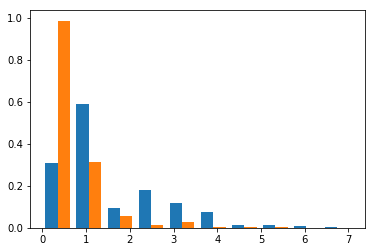

208473 0.797714643039


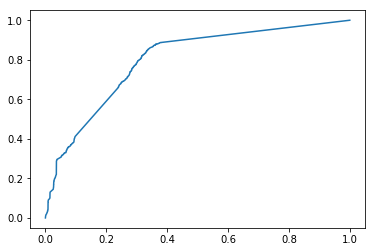

[3]


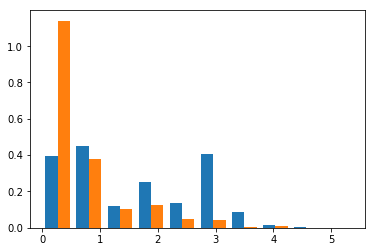

212425 0.756783690136


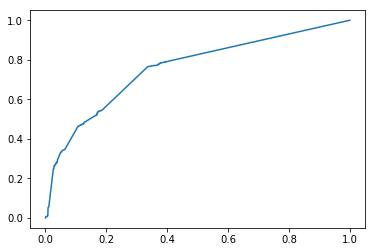

[2, 3]


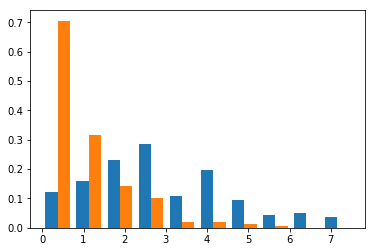

241149 0.839483860264


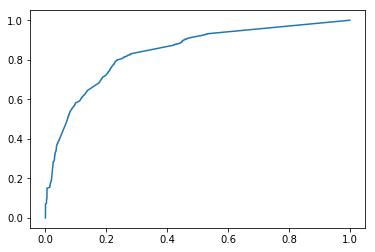

[6]


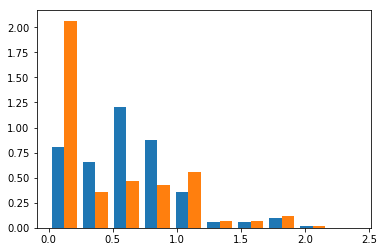

204449 0.630525175918


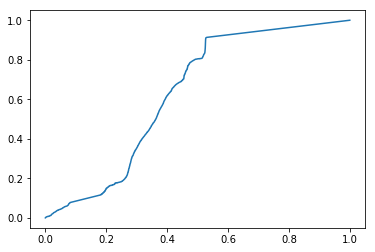

[11]


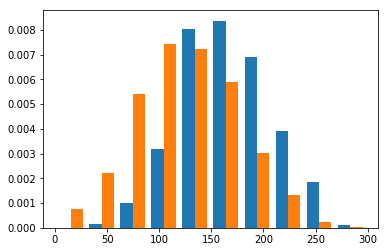

243279 0.740876150306


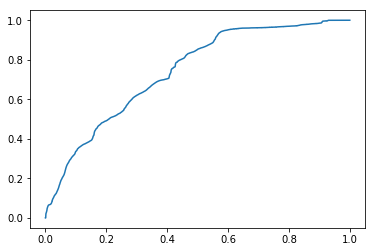

In [4]:
# Un normalized
for codes in [[1], [2], [3], [2, 3], [6], [11]]:
    correct, feature = [], []
    for protein, ligands in data.items():
        for i, (ligand1, poses1) in enumerate(ligands.items()[:10]):
            for ligand2, poses2 in ligands.items()[i+1:10]:
                # So we will be comparable to the below
                norm = get_norm(poses1, poses2, codes)
                if not norm: continue
                for pose1 in poses1:
                    for pose2 in poses2:
                        correct += [(pose1[-1] < 2.0) * (pose2[-1] < 2.0)]
                        feature += [overlap(pose1, pose2, codes)]
    correct, feature = np.array(correct), np.array(feature)
    
    print codes
    native = feature[correct == 1]
    decoy  = feature[correct == 0]
    plt.hist([native, decoy], normed = True)
    plt.show()
    
    print feature.shape[0], roc_auc_score(correct, feature)
    fpr, tpr, thresh = roc_curve(correct, feature)
    plt.plot(fpr, tpr)
    plt.show()

[1]


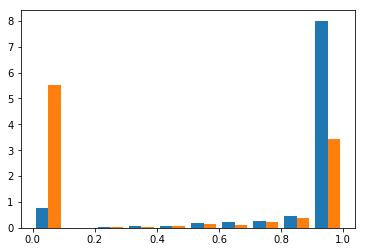

74406 0.764775636396


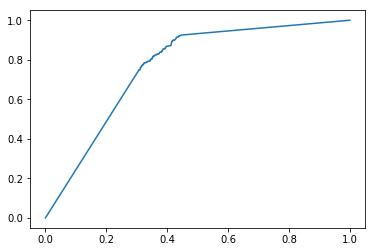

[2]


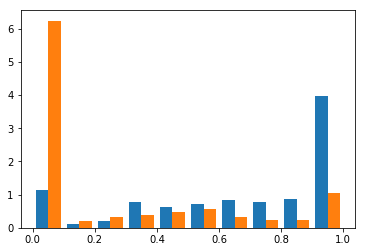

208473 0.795450505394


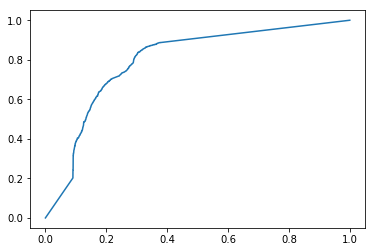

[3]


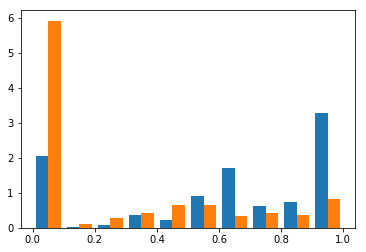

212425 0.754103959019


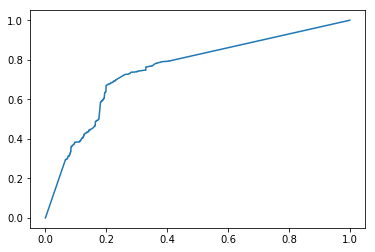

[2, 3]


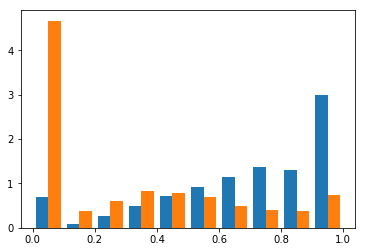

241149 0.803194338991


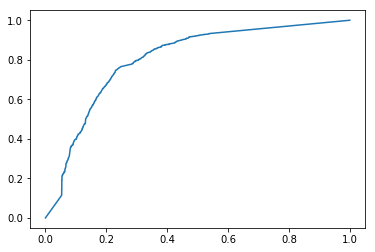

[6]


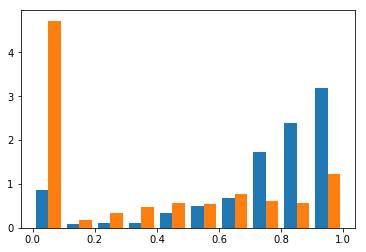

204449 0.769607048899


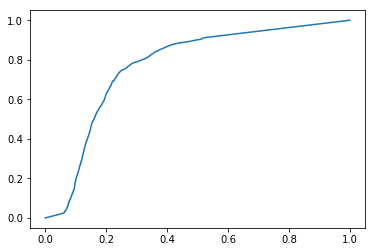

[11]


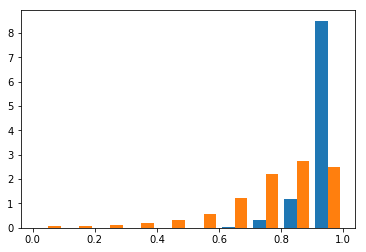

243279 0.871985035098


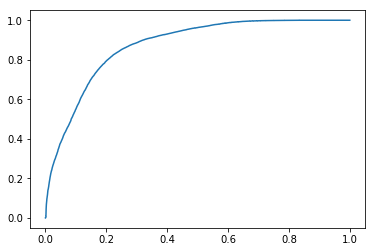

In [5]:
# Normalized
for codes in [[1], [2], [3], [2, 3], [6], [11]]:
    correct, feature = [], []
    for protein, ligands in data.items():
        for i, (ligand1, poses1) in enumerate(ligands.items()[:10]):
            for ligand2, poses2 in ligands.items()[i+1:10]:
                norm = get_norm(poses1, poses2, codes)
                if not norm: continue
                for pose1 in poses1:
                    for pose2 in poses2:
                        correct += [(pose1[-1] < 2.0) * (pose2[-1] < 2.0)]
                        feature += [overlap(pose1, pose2, codes) / norm]
    correct, feature = np.array(correct), np.array(feature)
    
    print codes
    native = feature[correct == 1]
    decoy  = feature[correct == 0]
    plt.hist([native, decoy], normed = True)
    plt.show()
    
    print feature.shape[0], roc_auc_score(correct, feature)
    fpr, tpr, thresh = roc_curve(correct, feature)
    plt.plot(fpr, tpr)
    plt.show()

# How well do features separate native and decoy poses? (ligand average)

[1]


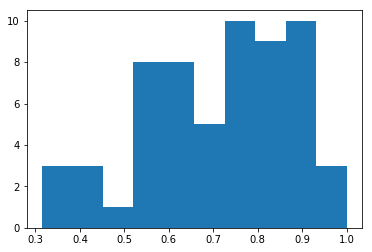

60 0.713622894182
[2]


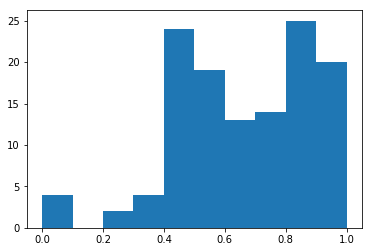

125 0.658691782252
[3]


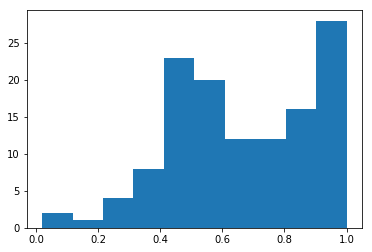

126 0.665570676024
[2, 3]


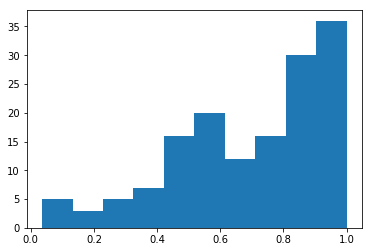

150 0.695498120061
[6]


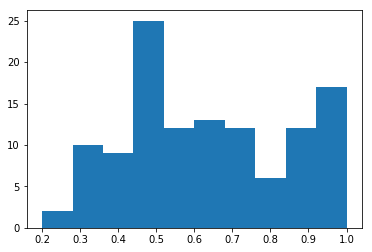

118 0.630813526157
[11]


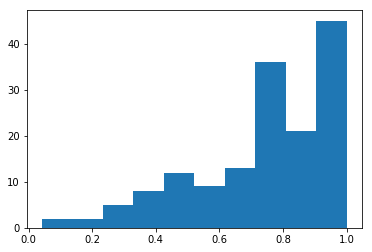

153 0.737246263409


In [6]:
# In ligand average case normalization has no effect

for codes in [[1], [2], [3], [2, 3], [6], [11]]:
    print codes
    aucs = []
    for protein, ligands in data.items():
        for i, (ligand1, poses1) in enumerate(ligands.items()[:10]):
            for ligand2, poses2 in ligands.items()[i+1:10]:
                norm = get_norm(poses1, poses2, codes)
                if not norm: continue
                correct, feature = [], []
                for pose1 in poses1:
                    for pose2 in poses2:
                        correct += [(pose1[-1] < 2.0) * (pose2[-1] < 2.0)]
                        feature += [overlap(pose1, pose2, codes)]
                if min(correct) == max(correct): continue
                aucs += [roc_auc_score(correct, feature)]
    plt.hist(aucs)
    plt.show()
    print len(aucs), np.mean(aucs)

# How well do energies seperate?

(1,)


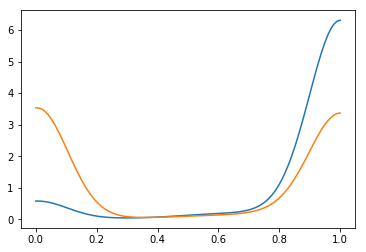

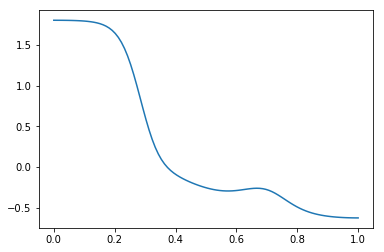

(2,)


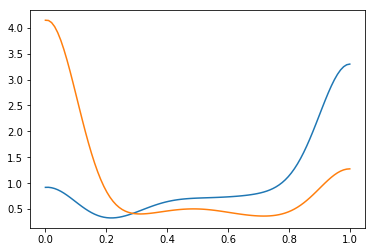

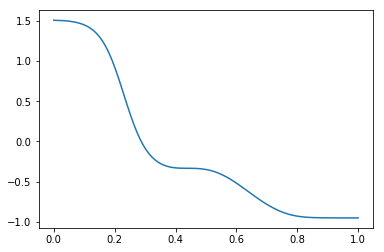

(3,)


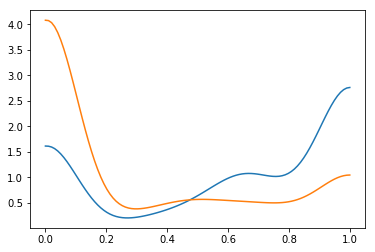

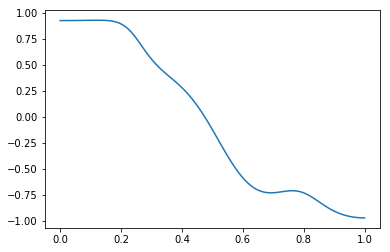

(2, 3)


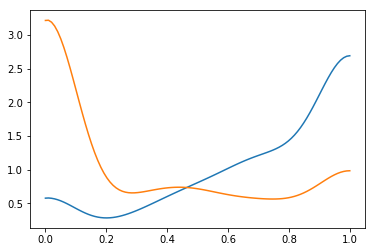

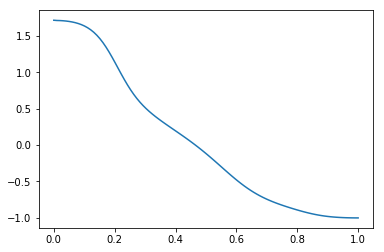

(6,)


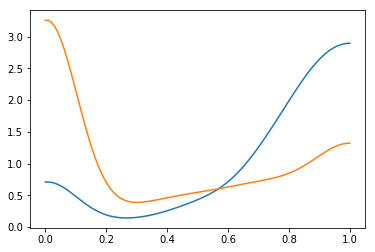

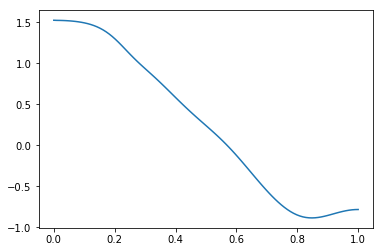

(11,)


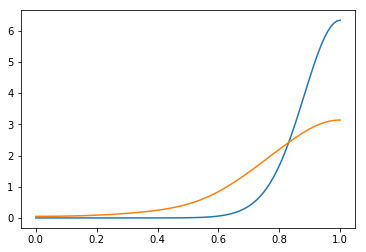

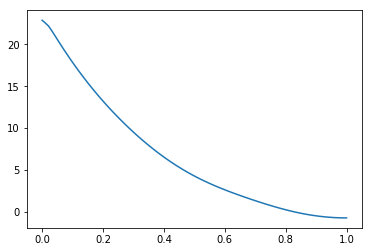

In [9]:
stats = {}
for codes in [[1], [2], [3], [2, 3], [6], [11]]:
    codes = tuple(codes)
    print codes
    correct, feature = [], []
    for protein, ligands in data.items():
        for i, (ligand1, poses1) in enumerate(ligands.items()[:10]):
            for ligand2, poses2 in ligands.items()[i+1:10]:
                norm = get_norm(poses1, poses2, codes)
                if not norm: continue
                for pose1 in poses1:
                    for pose2 in poses2:
                        correct += [(pose1[-1] < 2.0) * (pose2[-1] < 2.0)]
                        feature += [overlap(pose1, pose2, codes) / norm]
    correct, feature = np.array(correct), np.array(feature)
    
    stats[codes] = {}
    stats[codes]['native'] = DensityEstimate(reflect=True, domain = (0, 1), points = 100, sd = 0.1
                                            ).fit(feature[correct==1])
    stats[codes]['reference'] = DensityEstimate(reflect=True, domain = (0, 1), points = 100, sd = 0.1
                                               ).fit(feature)
    plt.plot(stats[codes]['native'].x, stats[codes]['native'].fx)
    plt.plot(stats[codes]['reference'].x, stats[codes]['reference'].fx)
    plt.show()
    
    stats[codes]['ratio'] = stats[codes]['native'].ratio(stats[codes]['reference'])
    plt.plot(stats[codes]['ratio'].x, -np.log(stats[codes]['ratio'].fx))
    plt.show()

In [10]:
def get_aucs(codes, ratio, w):
    aucs = []
    for protein, ligands in data.items():
        for i, (ligand1, poses1) in enumerate(ligands.items()[:10]):
            for ligand2, poses2 in ligands.items()[i+1:10]:
                norm = get_norm(poses1, poses2, codes)
                if not norm: continue
                correct, feature, gscores = [], [], []
                for pose1 in poses1:
                    for pose2 in poses2:
                        correct += [(pose1[-1] < 2.0) * (pose2[-1] < 2.0)]
                        feature += [-np.log(ratio(overlap(pose1, pose2, codes)/norm))]
                        gscores += [pose1[0]+pose2[0]]
                correct, feature, gscores = np.array(correct), np.array(feature), np.array(gscores)
                if correct.min() == correct.max(): continue
                aucs += [roc_auc_score(1-correct, w*gscores + feature)]
    return aucs

for codes in [[1], [2], [3], [2, 3], [6], [11]]:
    codes = tuple(codes)
    print codes
    for w in np.linspace(0, 3, 9):
        aucs = get_aucs(codes, stats[codes]['ratio'], w)
        print w, np.mean(aucs)
    aucs = get_aucs(codes, stats[codes]['ratio'], 1000)
    print 1000, np.mean(aucs)
    print

(1,)
0.0 0.713609499143
0.375 0.731844159087
0.75 0.734975482728
1.125 0.734803716956
1.5 0.733323891789
1.875 0.731087402584
2.25 0.728916315784
2.625 0.726705101892
3.0 0.724631104914
1000 0.68370000662

(2,)
0.0 0.658691782252
0.375 0.734998192948
0.75 0.740875626948
1.125 0.741724939853
1.5 0.741119096415
1.875 0.740612502632
2.25 0.738001349973
2.625 0.735187750487
3.0 0.733339250728
1000 0.708773446527

(3,)
0.0 0.665323917345
0.375 0.751600680125
0.75 0.755828899114
1.125 0.757725151638
1.5 0.756504234078
1.875 0.752915976174
2.25 0.749970415491
2.625 0.748016076072
3.0 0.746360494283
1000 0.71318694303

(2, 3)
0.0 0.695498226898
0.375 0.739716777271
0.75 0.744961533623
1.125 0.747823208575
1.5 0.746862861691
1.875 0.744648979249
2.25 0.741995211055
2.625 0.738873121824
3.0 0.735959416912
1000 0.702204930852

(6,)
0.0 0.606090708248
0.375 0.731182467262
0.75 0.748583790481
1.125 0.749691525982
1.5 0.74724710917
1.875 0.744784593132
2.25 0.742216664114
2.625 0.739489615698
3.0 0.

In [23]:
# Joint performance

def joint_performance(all_codes, w=1):
    print all_codes
    aucs = []
    for protein, ligands in data.items():
        for i, (ligand1, poses1) in enumerate(ligands.items()[:10]):
            for ligand2, poses2 in ligands.items()[i+1:10]:
                correct = []
                for pose1 in poses1:
                        for pose2 in poses2:
                            correct += [(pose1[-1] < 2.0) * (pose2[-1] < 2.0)]
                correct = np.array(correct)
                if correct.min() == correct.max(): continue

                scores = w*np.array([pose1[0] + pose2[0] for pose1 in poses1 for pose2 in poses2])
                for codes in all_codes:
                    codes = tuple(codes)
                    norm = get_norm(poses1, poses2, codes)
                    if not norm: continue
                    score = []
                    for pose1 in poses1:
                        for pose2 in poses2:
                            score += [-np.log(stats[codes]['ratio'](overlap(pose1, pose2, codes)/norm))]
                    scores += np.array(score)  
                aucs += [roc_auc_score(1-correct, scores)]
    plt.hist(aucs)
    plt.show()
    print np.mean(aucs)

[[1], [2], [3], [6], [11]]


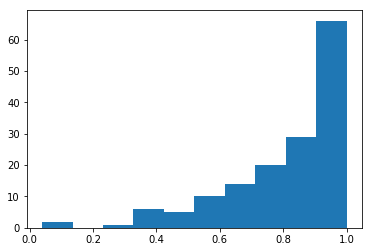

0.80842950162
[[1], [2, 3], [6], [11]]


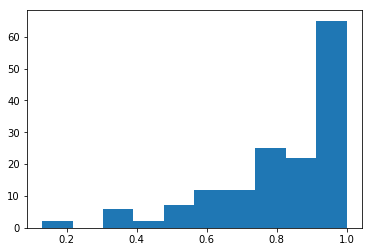

0.815050954264
[[1], [2, 3], [11]]


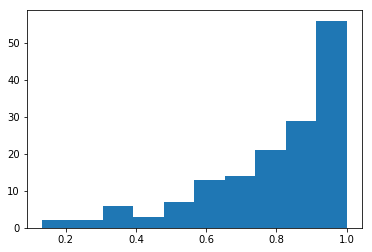

0.796592396582
[[1], [2, 3]]


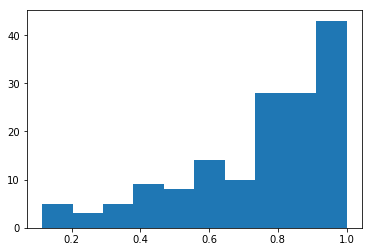

0.746986350186
[[2, 3]]


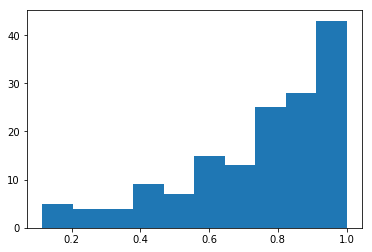

0.744638405543
[[2], [3]]


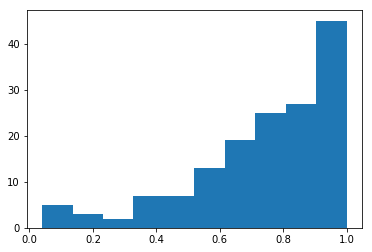

0.738670938528
[[]]


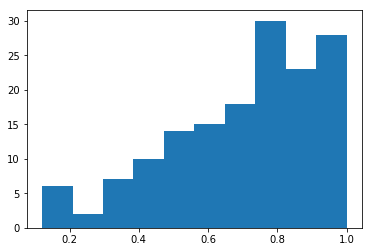

0.701651333384


In [22]:
joint_performance([[1], [2], [3], [6], [11]])
joint_performance([[1], [2, 3], [6], [11]])
joint_performance([[1], [2, 3], [11]])
joint_performance([[1], [2, 3]])
joint_performance([[2, 3]])
joint_performance([[2], [3]])
joint_performance([[]])

0.0
[[1], [2, 3], [6], [11]]


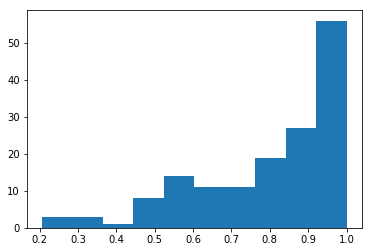

0.7992466062
0.333333333333
[[1], [2, 3], [6], [11]]


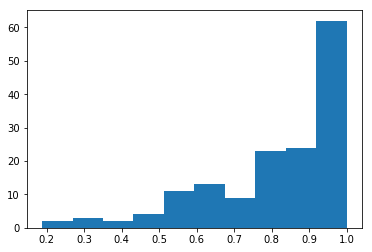

0.81285884608
0.666666666667
[[1], [2, 3], [6], [11]]


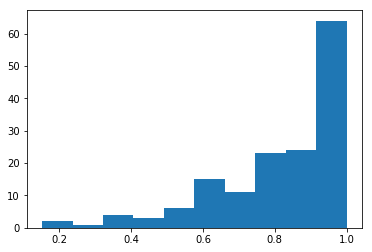

0.816016149808
1.0
[[1], [2, 3], [6], [11]]


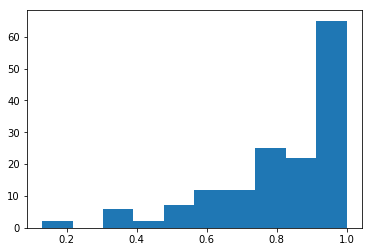

0.815050954264
1.33333333333
[[1], [2, 3], [6], [11]]


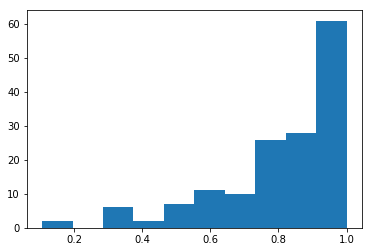

0.813023563862
1.66666666667
[[1], [2, 3], [6], [11]]


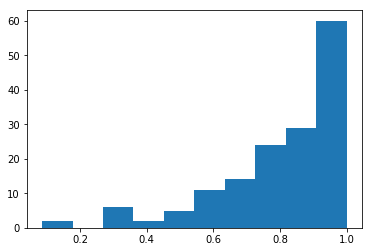

0.809976306574
2.0
[[1], [2, 3], [6], [11]]


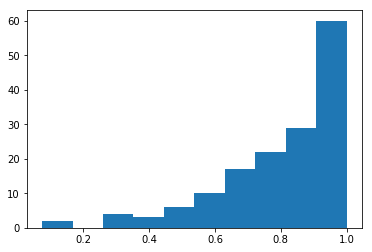

0.806172656008
2.33333333333
[[1], [2, 3], [6], [11]]


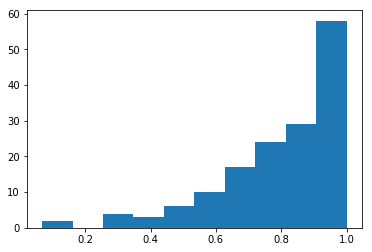

0.802399475414
2.66666666667
[[1], [2, 3], [6], [11]]


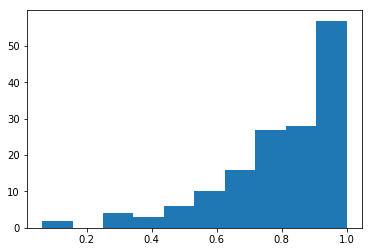

0.79833147104
3.0
[[1], [2, 3], [6], [11]]


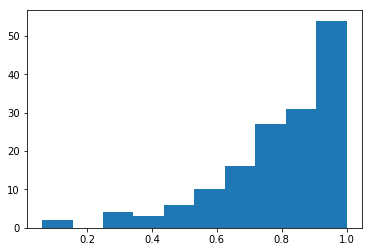

0.794286472751


In [26]:
for w in np.linspace(0, 3, 10):
    print w
    joint_performance([[1], [2, 3], [6], [11]], w)

0.0
[[1], [2], [3], [6], [11]]


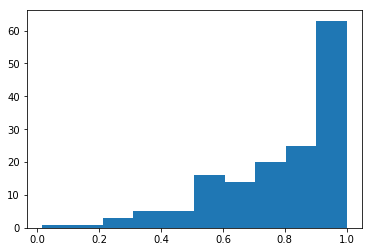

0.788861235585
0.333333333333
[[1], [2], [3], [6], [11]]


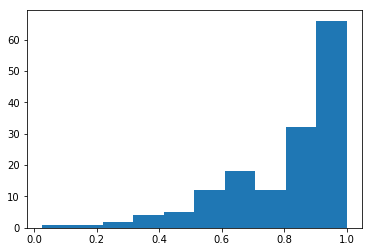

0.804766738542
0.666666666667
[[1], [2], [3], [6], [11]]


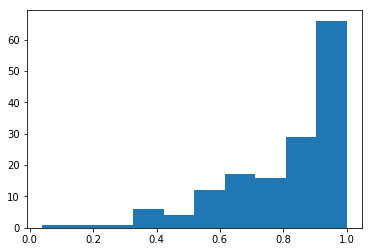

0.80872959391
1.0
[[1], [2], [3], [6], [11]]


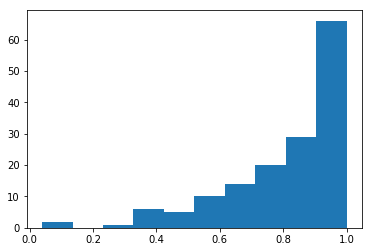

0.80842950162
1.33333333333
[[1], [2], [3], [6], [11]]


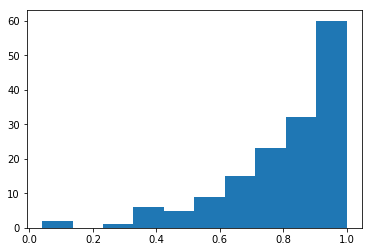

0.806284122471
1.66666666667
[[1], [2], [3], [6], [11]]


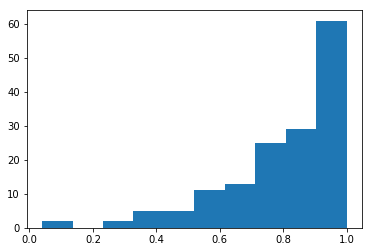

0.803508502397
2.0
[[1], [2], [3], [6], [11]]


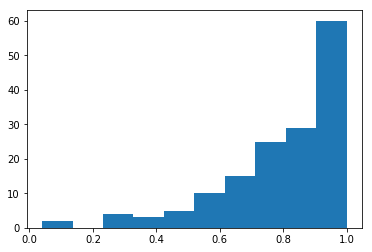

0.80033069084
2.33333333333
[[1], [2], [3], [6], [11]]


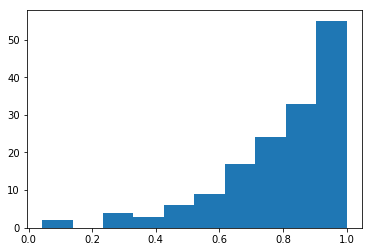

0.796552477526
2.66666666667
[[1], [2], [3], [6], [11]]


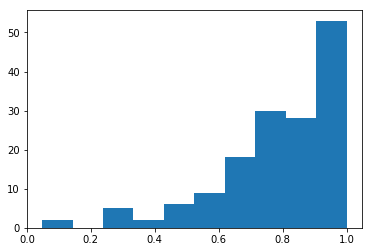

0.792748055538
3.0
[[1], [2], [3], [6], [11]]


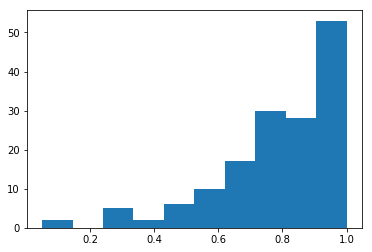

0.789440692756


In [27]:
for w in np.linspace(0, 3, 10):
    print w
    joint_performance([[1], [2], [3], [6], [11]], w)

# Normalization factors

In [ ]:
for codes in [[1], [2], [3], [2, 3], [6], [11]]:
    norms = []
    for protein, ligands in data.items():
        for i, (ligand1, poses1) in enumerate(ligands.items()[:10]):
            for ligand2, poses2 in ligands.items()[i+1:10]:
                norms += [get_norm(poses1, poses2, codes)]
    plt.title(codes)
    print len(norms)
    plt.hist(norms, bins = 50)
    plt.show()

# Compute Native, Reference Distributions for various normalization factors

- In all cases, proper weighting of the reference distribution closes the gap between the native and reference distributions, but there is still a tendency for similar interactions to be made.

In [ ]:
# native, decoy for different normalization factors
for codes in [[1], [2], [3], [6]]:
    for total in [1, 2, 3, 4]:
        all_proteins, all_ligands = set(), set()
        native, scores, p_glide = [], [], []
        for protein, ligands in data.items():
            for i, (ligand1, poses1) in enumerate(ligands.items()[:15]):
                for ligand2, poses2 in ligands.items()[i+1:15]:
                    norm = get_norm(poses1, poses2, codes)
                    if norm != total: continue
                    for rank1, pose1 in poses1.items():
                        if rank1 >= max_poses: continue
                        for rank2, pose2 in poses2.items():
                            if rank2 >= max_poses: continue
                            native += [(pose1[2] <= 2) * (pose2[2] <= 2)]
                            scores += [overlap(pose1, pose2, codes)]
                            p_glide += [  interpolate(pose1[0], p_x, p_y)
                                        * interpolate(pose2[0], p_x, p_y)]
                            all_proteins.add(protein)
                            all_ligands.add(ligand1)
                            all_ligands.add(ligand2)
                        
        native, scores, p_glide = np.array(native), np.array(scores), np.array(p_glide)
        if not np.sum(native): continue
        print total, codes, len(native)
        print len(all_ligands), list(all_proteins)
        print (np.log(np.sum(scores[native == 1] == 0)) - np.log(np.sum(p_glide[scores==0])),
               np.log(np.sum(scores[native == 1] == total)) - np.log(np.sum(p_glide[scores==total])))
        f, ax = plt.subplots(1, 2, figsize = (12, 5))
        ax[0].hist([scores[native == 1], scores], normed = True)
        ax[1].hist([scores[native == 1], scores],
                 weights = [[1]*np.sum(native), p_glide], normed = True)
        plt.show()

In [ ]:
# native, decoy  merged
for codes in [[1], [2], [3], [6]]:
    all_proteins, all_ligands = set(), set()
    native, scores, p_glide = [], [], []
    for protein, ligands in data.items():
        for i, (ligand1, poses1) in enumerate(ligands.items()[:15]):
            for ligand2, poses2 in ligands.items()[i+1:15]:
                norm = get_norm(poses1, poses2, codes)
                if norm not in [1, 2, 3, 4]: continue
                for rank1, pose1 in poses1.items():
                    if rank1 >= max_poses: continue
                    for rank2, pose2 in poses2.items():
                        if rank2 >= max_poses: continue
                        native += [(pose1[2] <= 2) * (pose2[2] <= 2)]
                        scores += [overlap(pose1, pose2, codes) / float(norm)]
                        p_glide += [  interpolate(pose1[0], p_x, p_y)
                                    * interpolate(pose2[0], p_x, p_y)]
                        all_proteins.add(protein)
                        all_ligands.add(ligand1)
                        all_ligands.add(ligand2)

    native, scores, p_glide = np.array(native), np.array(scores), np.array(p_glide)
    if not np.sum(native): continue
    print '1, 2, 3, 4', codes, len(native)
    print len(all_ligands), list(all_proteins)
    print (np.log(np.sum(scores[native == 1] == 0)) - np.log(np.sum(p_glide[scores==0])),
           np.log(np.sum(scores[native == 1] == 1)) - np.log(np.sum(p_glide[scores==1])))
    f, ax = plt.subplots(1, 2, figsize = (12, 5))
    ax[0].hist([scores[native == 1], scores], normed = True)
    ax[1].hist([scores[native == 1], scores],
             weights = [[1]*np.sum(native), p_glide], normed = True)
    plt.show()

# P made in a native pose given made in at least one pose

In [ ]:
for codes in [[1], [2], [3], [6]]:
    native, scores, p_glide = [], [], []
    for protein, ligands in data.items():
        for i, (ligand1, poses1) in enumerate(ligands.items()[:10]):
            for ligand2, poses2 in ligands.items()[i+1:10]:
                made = set()
                for rank1, pose1 in poses1.items():
                    if rank1 >= max_poses: continue
                    for rank2, pose2 in poses2.items():
                        if rank2 >= max_poses: continue
                        for (c, r), score1 in pose1[-1].items():
                            if c in codes and (c, r) in pose2[-1]:
                                if np.sqrt(score1*pose2[-1][(c, r)]) == 1.0:
                                    made.add((c, r))
                for rank1, pose1 in poses1.items():
                    if rank1 >= max_poses: continue
                    for rank2, pose2 in poses2.items():
                        if rank2 >= max_poses: continue
                        for k in made:
                            score1 = pose1[-1][k] if k in pose1[-1] else 0
                            score2 = pose2[-1][k] if k in pose2[-1] else 0
                            native += [(pose1[2] <= 2) * (pose2[2] <= 2)]
                            scores += [np.sqrt(score1*score2)]
                            p_glide += [  interpolate(pose1[0], p_x, p_y)
                                        * interpolate(pose2[0], p_x, p_y)]

    native, scores, p_glide = np.array(native), np.array(scores), np.array(p_glide)
    print codes, len(native)
    f, ax = plt.subplots(1, 2, figsize = (12, 5))
    ax[0].hist([scores[native == 1], scores], normed = True)
    ax[1].hist([scores[native == 1], scores],
             weights = [[1]*np.sum(native), p_glide], normed = True)
    plt.show()

# Is there a difference between (0, 0) and (0, 1)?

In [ ]:
for codes in [[1], [2], [3], [6]]:
    native, scores, p_glide = [], [], []
    for protein, ligands in data.items():
        for i, (ligand1, poses1) in enumerate(ligands.items()[:15]):
            for ligand2, poses2 in ligands.items()[i+1:15]:
                made = set()
                for rank1, pose1 in poses1.items():
                    if rank1 > max_poses: continue
                    for rank2, pose2 in poses2.items():
                        if rank2 > max_poses: continue
                        for (c, r), score1 in pose1[-1].items():
                            if c in codes and (c, r) in pose2[-1]:
                                if np.sqrt(score1*pose2[-1][(c, r)]) == 1.0:
                                    made.add((c, r))
                for rank1, pose1 in poses1.items():
                    if rank1 > max_poses: continue
                    for rank2, pose2 in poses2.items():
                        if rank2 > max_poses: continue
                        for k in made:
                            score1 = pose1[-1][k] if k in pose1[-1] else 0
                            score2 = pose2[-1][k] if k in pose2[-1] else 0
                            if score1 not in [0, 1] or score2 not in [0, 1]: continue 
                            native += [(pose1[2] <= 2) * (pose2[2] <= 2)]
                            scores += [(score1 == 1) + (score2 == 1)]
                            p_glide += [  interpolate(pose1[0], p_x, p_y)
                                        * interpolate(pose2[0], p_x, p_y)]

    native, scores, p_glide = np.array(native), np.array(scores), np.array(p_glide)
    print codes, len(native), np.sum(native)
    f, ax = plt.subplots(2, 2, figsize = (12, 10))
    ax[0, 0].hist([scores[native == 1], scores], normed = True)
    ax[0, 1].hist([scores[native == 1], scores],
                   weights = [[1]*np.sum(native), p_glide], normed = True)
    ax[1, 0].plot([np.sum(scores[native == 1] == i) / np.sum(scores == i).astype(float)
                   for i in range(3)])
    ax[1, 1].plot([np.sum(scores[native == 1] == i) / np.sum(p_glide[scores == i])
                   for i in range(3)])
    plt.show()

# Given that a ligand makes an interaction in at least one pose, what is the likelihood that the interaction is native?

In [ ]:
for codes in [[1], [2], [3], [6], [11]]:
    native, scores, p_glide = [], [], []
    for protein, ligands in data.items():
        if protein in ['B1AR', 'B2AR']: continue
        for i, (ligand, poses) in enumerate(ligands.items()[:15]):
            made = set()
            for rank, pose in poses.items():
                if rank > max_poses: continue
                for (c, r), score in pose[-1].items():
                    if c in codes and score == 1.0:
                        made.add((c, r))
            for rank, pose in poses.items():
                if rank > max_poses: continue
                for k in made:
                    native += [pose[2] <= 2]
                    scores += [pose[-1][k] if k in pose[-1] else 0]
                    p_glide += [interpolate(pose[0], p_x, p_y)]

    native, scores, p_glide = np.array(native), np.array(scores), np.array(p_glide)
    print codes, len(native), np.sum(native)
    f, ax = plt.subplots(2, 2, figsize = (12, 10))
    ax[0, 0].hist([scores[native == 1], scores], normed = True)
    ax[0, 1].hist([scores[native == 1], scores],
                   weights = [[1]*np.sum(native), p_glide], normed = True)
    ax[1, 0].plot([np.sum(scores[native == 1] == i) / np.sum(scores == i).astype(float)
                   for i in range(3)])
    ax[1, 1].plot([np.sum(scores[native == 1] == i) / np.sum(p_glide[scores == i])
                   for i in range(3)])
    plt.show()

In [ ]:
T = 1.11
C = 8.0

T = 1.0
C = 8.8

for codes in [[1], [2], [3], [6], [11]]:
    native, scores, p_glide = [], [], []
    for protein, ligands in data.items():
        if protein in ['B1AR', 'B2AR']: continue
        for i, (ligand, poses) in enumerate(ligands.items()[:15]):
            made = set()
            for rank, pose in poses.items():
                if rank > max_poses: continue
                for (c, r), score in pose[-1].items():
                    if c in codes and score == 1.0:
                        made.add((c, r))
            for rank, pose in poses.items():
                if rank > max_poses: continue
                for k in made:
                    native += [pose[2] <= 2]
                    scores += [pose[-1][k] if k in pose[-1] else 0]
                    p_glide += [np.exp(-pose[0]/T) / (np.exp(-pose[0]/T) + np.exp(C))]
                    #p_glide += [np.exp(-pose[0]/T)]

    native, scores, p_glide = np.array(native), np.array(scores), np.array(p_glide)
    print codes, len(native), np.sum(native)
    f, ax = plt.subplots(2, 2, figsize = (12, 10))
    ax[0, 0].hist([scores[native == 1], scores], normed = True)
    ax[0, 1].hist([scores[native == 1], scores],
                   weights = [[1]*np.sum(native), p_glide], normed = True)
    ax[1, 0].plot([np.sum(scores[native == 1] == i) / np.sum(scores == i).astype(float)
                   for i in range(3)])
    ax[1, 1].plot([np.sum(scores[native == 1] == i) / np.sum(p_glide[scores == i])
                   for i in range(3)])
    plt.show()

In [ ]:
for codes in [[1], [2], [3], [6], [11]]:
    native, scores, p_glide = [], [], []
    for protein, ligands in data.items():
        for i, (ligand, poses) in enumerate(ligands.items()[:15]):
            for rank, pose in poses.items():
                if rank > max_poses: continue
                for (c, r), score in pose[-1].items():
                    if c in codes:
                        native  += [pose[2] <= 2]
                        scores  += [pose[-1][(c,r)]]
                        p_glide += [interpolate(pose[0], p_x, p_y)]
    native, scores, p_glide = np.array(native), np.array(scores), np.array(p_glide)
    print codes, len(native), np.sum(native)
    f, ax = plt.subplots(1, 2, figsize = (12, 5))
    ax[0].hist([scores[native == 1], scores], normed = True)
    ax[1].hist([scores[native == 1], scores],
                   weights = [[1]*np.sum(native), p_glide], normed = True)
    plt.show()

# Is there a dependency on number of interactions and glide performance? I.e. if in its native pose a ligand makes 1 hbond is it more or less likely to be correctly predicted than a ligand that makes 2 hbonds?

In [ ]:
for codes in [[1], [2], [3], [6]]:
    native, scores, p_glide = [], [], []
    for protein, ligands in data.items():
        for i, (ligand, poses) in enumerate(ligands.items()):
            count = None
            for rank, pose in poses.items():
                if rank > max_poses: continue
                if pose[2] <= 2:
                    count = 0
                    for (c, r), score in pose[-1].items():
                        if c in codes and score == 1.0:
                            count += 1
                    break
            if count is None: continue
            for rank, pose in poses.items():
                if rank > max_poses: continue
                native += [pose[2] <= 2]
                scores += [count]
                p_glide += [interpolate(pose[0], p_x, p_y)]

    native, scores, p_glide = np.array(native), np.array(scores), np.array(p_glide)
    print codes, len(native), np.sum(native)
    f, ax = plt.subplots(2, 2, figsize = (12, 10))
    ax[0, 0].hist([scores[native == 1], scores])
    ax[0, 1].hist([scores[native == 1], scores],
                   weights = [[1]*np.sum(native), p_glide])
    ax[1, 0].plot([np.sum(scores[native == 1] == i) / np.sum(scores == i).astype(float)
                   for i in range(scores.max()+1)])
    ax[1, 1].plot([np.sum(scores[native == 1] == i) / np.sum(p_glide[scores == i])
                   for i in range(scores.max()+1)])
    plt.show()

In [ ]:
X = np.linspace(0, 1, 10)
y = np.linspace(0, 1, 10)
x = .33
idx = 0
while x > X[idx]: idx += 1
print idx

if not idx:
    print y[0] # Avoid IndexError
else:
    d = X[idx] - X[idx-1]
    print (  y[idx-1]  * (X[idx] - x)/d
           + y[idx]    * (x - X[idx-1])/d)